In [1]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers.core import Dense, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU

import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
keras.backend.set_image_dim_ordering('th')

def YoloNet():
    model = Sequential()
    
    model.add(Convolution2D(16, 3, 3, border_mode='same',subsample=(1,1), input_shape=(3,448,448)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same'))
    
    model.add(Convolution2D(32, 3, 3, border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same'))
              
    model.add(Convolution2D(64, 3, 3, border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same'))
    
    model.add(Convolution2D(128, 3, 3, border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same'))
    
    model.add(Convolution2D(256,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same'))
    
    model.add(Convolution2D(512,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same'))
    
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(Dense(4096))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(1470))
    
    return model
    

In [3]:
# code based on:
# YAD2K https://github.com/allanzelener/YAD2K
# darkflow https://github.com/thtrieu/darkflow
# Darknet.keras https://github.com/sunshineatnoon/Darknet.keras
# xslittlegrass https://github.com/xslittlegrass/CarND-Vehicle-Detection
def load_weights(model,yolo_weight_file):
                
    data = np.fromfile(yolo_weight_file,np.float32)
    data=data[4:]
    
    index = 0
    for layer in model.layers:
        shape = [w.shape for w in layer.get_weights()]
        if shape != []:
            kshape,bshape = shape
            bia = data[index:index+np.prod(bshape)].reshape(bshape)
            index += np.prod(bshape)
            ker = data[index:index+np.prod(kshape)].reshape(kshape)
            index += np.prod(kshape)
            layer.set_weights([ker,bia])

In [4]:
yolo = YoloNet()

load_weights(yolo, 'yolov4.weights')

In [5]:
class Box:
    def __init__(self,classes):
        self.x = 0
        self.y = 0
        self.h = 0
        self.w = 0
        self.prob = 0.0
        self.overlap_idx = 0
        
    def area(self):
        return self.w * self.h

In [6]:
def convert_yolo_output_tensor_to_boxes(output_tensor, img_shape, threshold=0.2):

    #labels = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train","tvmonitor"]
    boxes = []
    C = 20
    B = 2
    S = 7
    car_label = 6
    img_h, img_w, _ = img_shape
    
    # split output tensor into P(class|object) for each grid cell, P(object) and [x,y,w,h] for each predicted box
    prob_class_obj = output_tensor[:S*S*C] # 7*7 * 20
    prob_obj = output_tensor[S*S*C:S*S*C + S*S*B] # 7*7 * B
    coord = output_tensor[S*S*C + S*S*B:] # 7*7 * 4B
    
    prob_class_obj = np.reshape(prob_class_obj, (S*S, C))
    prob_obj = np.reshape(prob_obj, (S*S, B))
    coord = np.reshape(coord, (S*S, 4*B))
    
    # cell width and height
    cell_w = 1.*img_w / S
    cell_h = 1.*img_h / S
    
    for i in range(S*S):
        row = i // S
        col = i % S
        for b in range(B):
            box = Box(C)
            box.x = (col + coord[i, 0]) * cell_w
            box.y = (row + coord[i, 1]) * cell_h
            box.w = (coord[i, 2] ** 1.8) * img_w
            box.h = (coord[i, 3] ** 1.8) * img_h
            # P(class) = P(class|object) * P(object)
            box.prob = prob_class_obj[i, car_label] * prob_obj[i, b]
            
            if (box.prob > threshold):
                boxes.append(box)

    return boxes


In [7]:
def change_coord(box):
    left = box.x - box.w/2.
    right = box.x + box.w/2.
    top = box.y - box.h/2.
    bottom = box.y + box.h/2.
    
    return left,right,top,bottom
        
def intersection(box1, box2):
    a1,c1,b1,d1 = change_coord(box1)
    a2,c2,b2,d2 = change_coord(box2)
    w = min(c1,c2) - max(a1,a2)
    h = min(d1,d2) - max(b1,b2)
    
    if (w < 0 or h < 0): return 0
    return w*h

def union(box1, box2):
    return box1.area() + box2.area() - intersection(box1, box2)
    
def iou(box1, box2):
    return intersection(box1,box2) / union(box1, box2)
    
def nms(bboxes, thresh=0.2):
    bboxes.sort(key=lambda b:b.prob, reverse=True)
#     print([(b.x, b.prob)for b in bboxes])
#     print('len before',len(bboxes))
    for i in range(len(bboxes)):
        if (bboxes[i].prob == 0): continue
        for j in range(i+1,len(bboxes)):
            if (iou(bboxes[i], bboxes[j]) > thresh):
                bboxes[j].prob = 0
#             print('iou=',iou(bboxes[i], bboxes[j]), ' ',bboxes[j].prob)
    bboxes = [b for b in bboxes if b.prob > 0]
    
#     print('len after',len(bboxes))
#     print([(b.x, b.prob)for b in bboxes])
    return bboxes

def combine_boxes(boxes):
    left = min([b.x - b.w/2. for b in boxes])
    right = max([b.x + b.w/2. for b in boxes])
    top = min([b.y - b.h/2. for b in boxes])
    bottom = max([b.y + b.h/2. for b in boxes])
    
    return (left,right,top,bottom)
    
    
def combine_overlapping_boxes(bboxes, overlap_thresh=0.001):
    
    combined_boxes = []
    
    # find all overlapping boxes
    current_overlap_idx = 0
    bboxes.sort(key=lambda b:b.x)
    for i in range(len(bboxes)):
        for j in range(i+1,len(bboxes)):
#             print(bboxes[i].x, bboxes[j].x, iou(bboxes[i], bboxes[j]))
            if (iou(bboxes[i], bboxes[j]) > overlap_thresh):
                # assign a new overlap idx
                if (bboxes[i].overlap_idx == 0):
                    current_overlap_idx += 1
                    bboxes[i].overlap_idx = current_overlap_idx
                    bboxes[j].overlap_idx = current_overlap_idx
                # assign the prev overlap idx
                bboxes[j].overlap_idx = bboxes[i].overlap_idx
                
#     # debug
#     for b in bboxes:
#         print(b, b.x, b.prob, b.overlap_idx)

    # combine them
    for i in range(1,current_overlap_idx+1):
        combined_boxes.append(combine_boxes([b for b in bboxes if b.overlap_idx==i]))
    
    combined_boxes.extend([change_coord(b) for b in bboxes if b.overlap_idx==0])
    
#     print([b for b in combined_boxes])
    return combined_boxes

In [8]:
def draw_bboxes(img, crop, boxes, color=(255,0,0), thickness=6):
    h, w, _ = img.shape

    ymin, ymax = crop[0]
    xmin, xmax = crop[1]
    for box in boxes:
#         left = int(box.x - box.w/2.)
#         right = int(box.x + box.w/2.)
#         top = int(box.y - box.h/2.)
#         bottom = int(box.y + box.h/2.)

        left = int(box[0])
        right = int(box[1])
        top = int(box[2])
        bottom = int(box[3])
        
        left = int(left*(xmax - xmin)/w + xmin)
        right = int(right*(xmax - xmin)/w + xmin)
        top = int(top*(ymax - ymin)/h + ymin)
        bottom = int(bottom*(ymax - ymin)/h + ymin)
        
        if(left < 0): left = 0;
        if(right > w-1): right = w-1;
        if(top < 0): top = 0;
        if(bottom > h-1): bottom = h-1;
        
#         print(left, box.prob)
        cv2.rectangle(img, (left, top), (right, bottom), color=color, thickness=thickness)           
        
    return img

In [9]:
def detect_cars(image):
    img_crop = image[300:650,500:,:]
    img = cv2.resize(img_crop, (448,448))
    img = np.transpose(img,(2,0,1))
    img = 2.0*img/255.0 - 1
    img = np.expand_dims(img, axis=0)

    result = yolo.predict(img)
    bboxes = convert_yolo_output_tensor_to_boxes(result[0], image.shape, threshold=0.16)
    bboxes = combine_overlapping_boxes(bboxes)
    
    img_result = draw_bboxes(image, [(300,650),(500,1280)], bboxes)
    return img_result

In [11]:
image = mpimg.imread('test_images/test5.jpg')
# result = detect_cars(image)
# plt.imshow(result)

### detect cars in test images

ValueError: cannot convert float NaN to integer

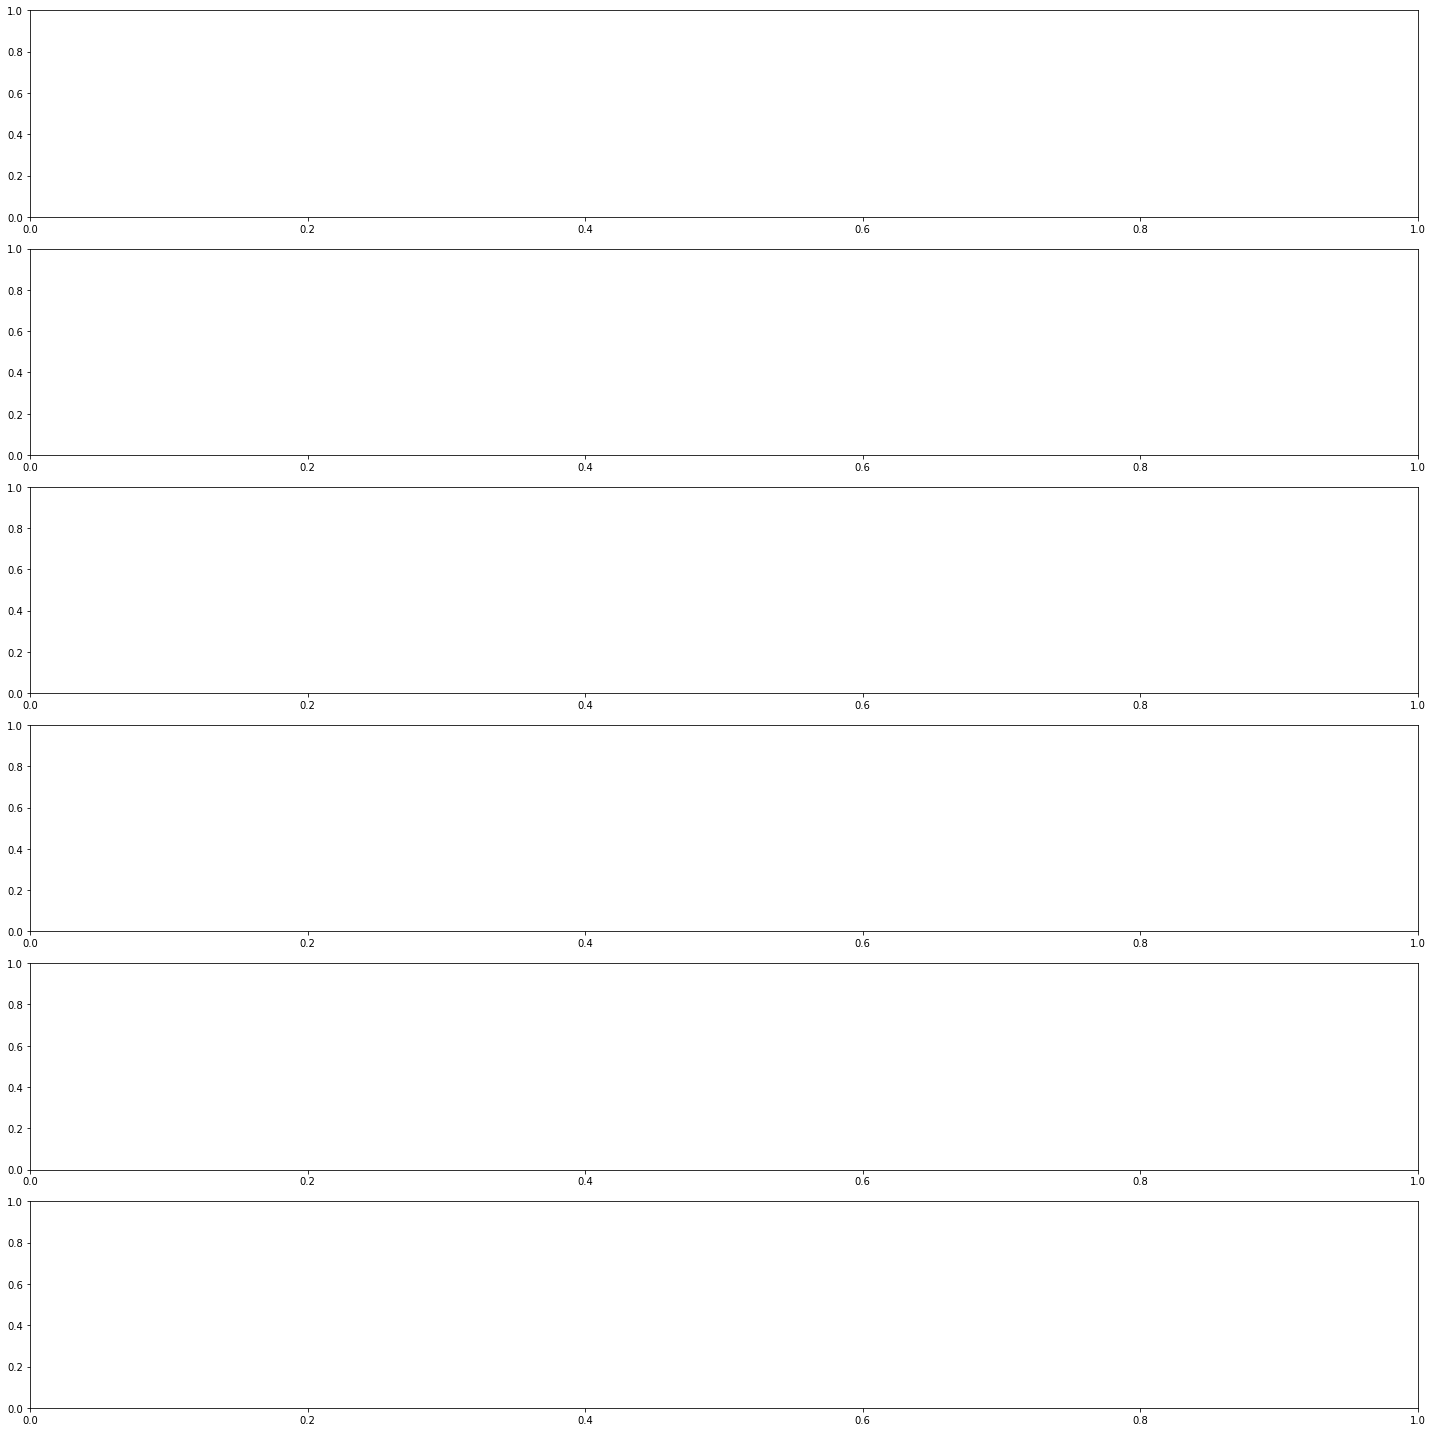

In [12]:
images = glob.glob('test_images/*.jpg')

f, axs = plt.subplots(len(images), 1, figsize=(20, 20))
f.tight_layout()
for i, fname in enumerate(images):
    image = mpimg.imread(fname)
    result = detect_cars(image)
    axs[i].imshow(result)
    axs[i].set_title(fname)
    axs[i].axis('off')
    
f.savefig('output_images/result_testimgs.png', bbox_inches='tight', pad_inches=0)

### apply to video

In [13]:
output = 'project_video_result_full2.mp4'
clip = VideoFileClip("project_video.mp4")
# clip_result = clip.fl_image(process_image).subclip(0,20)
clip_result = clip.fl_image(detect_cars)
%time clip_result.write_videofile(output, audio=False)

ValueError: cannot convert float NaN to integer